In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

from model import lorenz63_fdm
from assimilation import ExtendedKF, OI, EnKF

### Define functions

In [2]:
def plot_assim_result(result, X_nature, X_obs, rmse, stableidx, result_label=None):
    # plot assimilation result
    ts = np.arange(0, time, dt)
    t_obs = np.arange(0, time, obs_timeintv)

    # plot nature run and assimilation result
    fig, axs = plt.subplots(nrows=4, figsize=(20, 12))
    for i in range(3):
        axs[i].plot(ts, result[i,:], label=result_label)
        axs[i].plot(t_obs, X_obs[i,:], 'r.', label='Obs')
        axs[i].plot(ts, X_nature[i,:], color='red', alpha=0.3, label='Nature')
    
    # plot RMSE and stable index
    axs[3].plot(ts, rmse, c='grey', lw=0.8)
    bool_idx = stableidx > 0
    axs[3].scatter(ts[~bool_idx], rmse[~bool_idx], s=20, c='white')
    axs[3].scatter(ts[bool_idx], rmse[bool_idx], s=20, c=stableidx[bool_idx], cmap='Reds')
    axs[3].scatter(ts[::int(obs_timeintv/dt)], rmse[::int(obs_timeintv/dt)], s=5, marker='x')

    axs[0].set_title('X')
    axs[1].set_title('Y')
    axs[2].set_title('Z')
    axs[3].set_title('RMSE and instability')
    axs[3].set_xlabel('time')

    axs[0].legend()
    plt.tight_layout()
    return fig, axs


def gen_random_obserr(mean, var, size, obs_intv, random_state=None):
    """
    Generate random gaussian observation error.
    
    Parameters:
    ----------
    mean, var: scaler.
        Mean and variance for gaussian distribution.
    size: int.
        The size of output array.
    obs_intv: int.
        The observation interval length in the output array.
    random_state: int.
        Random state. Default is None and it will use np.random.randint.
        
    Return:
    ------
    obs_err: 1-d array.
        The array which observation error occurs every `obs_intv` and others are 0.
        
    EX:
    >>> gen_random_obserr(0, 1, 12, 4)
    array([-0.34889445,  0,  0,  0,  0.98370343,  0,  0,  0,
           0.58092283,  0,  0,  0])
    """
    if random_state is None:
        random_state = np.random.randint(0, 50)
    
    length = np.ceil(size/obs_intv) * obs_intv
    obs_err = np.zeros(int(length)).reshape((-1,obs_intv))
    
    rng = np.random.RandomState(random_state)
    obs_err[:,0] = rng.normal(mean, np.sqrt(var), size=obs_err.shape[0])
    obs_err = obs_err.ravel()[:size]
    return obs_err


def lorenz63_fdm(x0, ts, sigma=None, r=None, b=None):
    """Solve lorenz63 with finit difference method"""  
    if sigma is None:
        sigma = 10
    if r is None:
        r = 28
    if b is None:
        b = 8/3
    
    size = ts.size
    dt = ts[1] - ts[0]
    
    x = np.zeros((size,))
    y = np.zeros((size,))
    z = np.zeros((size,))
    x[0] = x0[0]
    y[0] = x0[1]
    z[0] = x0[2]
    
    for i in range(1, size):
        x[i] = x[i-1] + sigma * (y[i-1] - x[i-1]) * dt
        y[i] = y[i-1] + (r*x[i-1] - y[i-1] - x[i-1]*z[i-1]) * dt
        z[i] = z[i-1] + (x[i-1]*y[i-1] - b*z[i-1]) * dt
    
    return np.vstack((x, y, z))


def M(xi, yi, zi, dt, sigma=None, r=None, b=None):
    """tangent linear model for lorenz63_fdm"""
    if sigma is None:
        sigma = 10
    if r is None:
        r = 28
    if b is None:
        b = 8/3
    
    M = np.array([
        [1-sigma*dt, sigma*dt, 0],
        [r*dt-zi*dt, 1-dt, -xi*dt],
        [yi*dt, xi*dt, 1-b*dt]
    ])
    return M


def stability_index_lorenz63(x, y, z, sigma=None, r=None, b=None):
    if sigma is None:
        sigma = 10
    if r is None:
        r = 28
    if b is None:
        b = 8/3
        
    M = np.array([
        [-sigma, sigma, 0],
        [r-z, -1, -x],
        [y, x, -b]
    ])
    
    eigv, P = np.linalg.eig(M)
    r = eigv.real
    if np.all(r<0):
        # stable case
        return r.sum()
    else:
        # unstable case
        r[r<0] = 0
        return r.sum()

### Create nature run

In [3]:
time = 16
dt = 0.01
ts = np.arange(0, time, dt)
X0 = np.array([[8, 0, 30]]).T
X_nature = lorenz63_fdm(X0.ravel(), ts)
X_nature.shape

(3, 1600)

### Create normal observation

In [4]:
# observation parameters for each variables
obs_mean = [0, 0, 0]
obs_var = [2, 2, 2] 
random_state = [20, 21, 22]

# assimilate observation parameters
obs_timeintv = 0.08
obs_intv = int(obs_timeintv / dt)
cycle_num = int(time / obs_timeintv)

# construct observation error
size = int(time/dt)
X_obs_err = np.zeros((3, size))
for irow, (obsm, obsv, rst) in enumerate(zip(obs_mean, obs_var, random_state)):
    X_obs_err[irow,:] = gen_random_obserr(obsm, obsv, size, obs_intv, rst)
    
X_obs = X_nature + X_obs_err
X_obs = X_obs[:,::obs_intv]

### Initial condition

In [5]:
X_ini = X_nature[:,[0]] + np.array([[50], [40], [60]])

### Assimilation normal observation

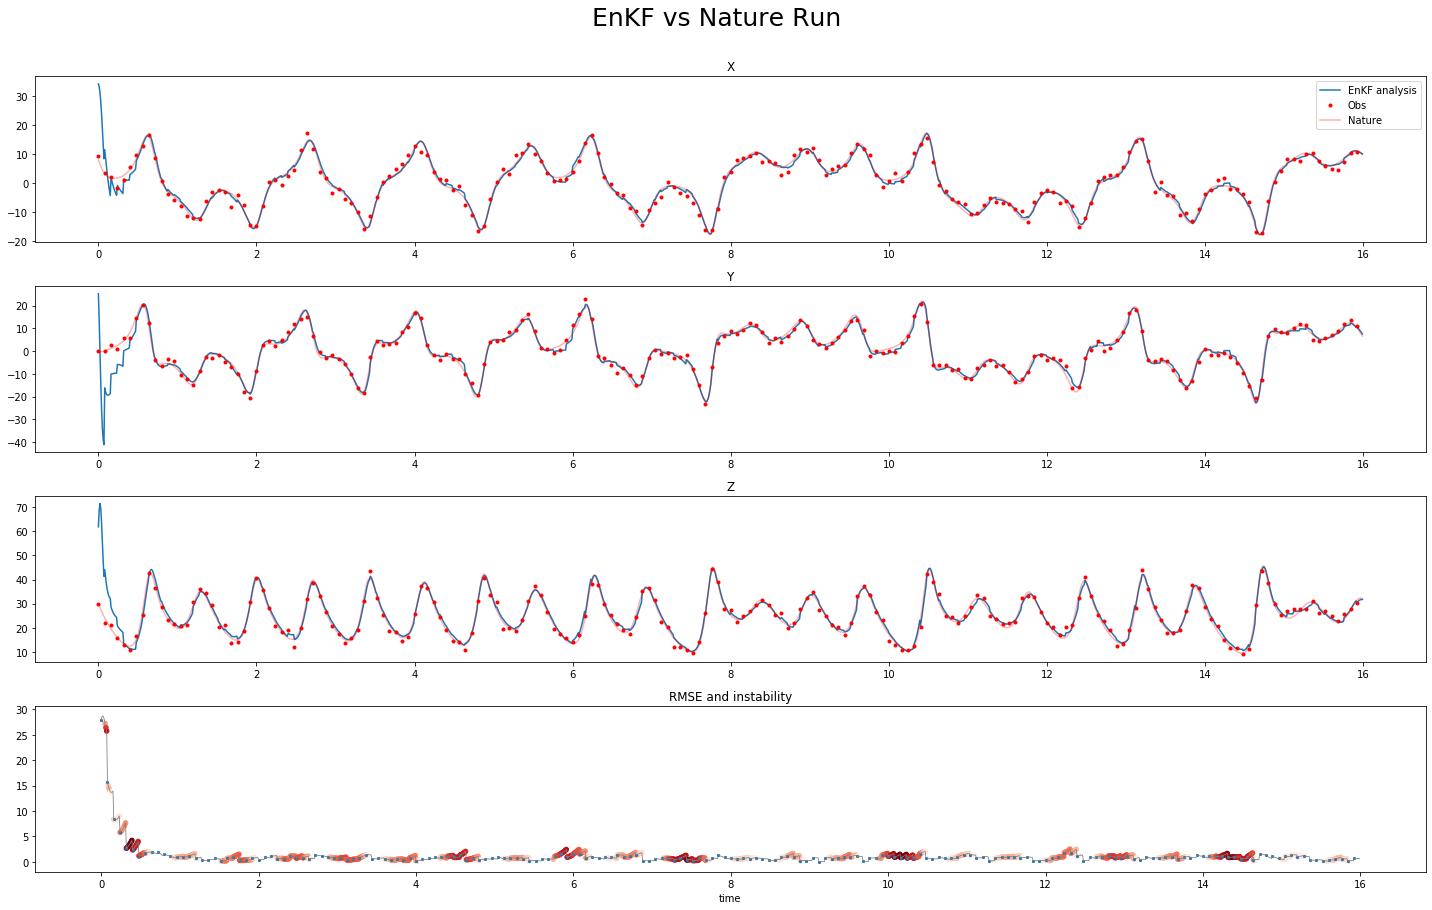

In [6]:
Pb = np.array([
    [ 95.92487549, 108.82721654,  13.52170192],
    [108.82721654, 135.97355097,  18.39642468],
    [ 13.52170192,  18.39642468,  64.98710037]
])
Pb *= 0.02

R = np.zeros((X_obs.shape[0], X_obs.shape[0]))
np.fill_diagonal(R, obs_var)

# generate initial ensemble
N_ens = 30
rng = np.random.RandomState(42)
X_ens_ini = rng.multivariate_normal(X_nature[:,0], Pb, size=N_ens).T  # (3, N_ens)
X_ens_ini += 55

enkf_params = {
    'X_ens_ini': X_ens_ini, 
    'obs': X_obs, 
    'obs_interv': 8, 
    'R': R, 
    'H_func': None, 
    'alpha': 0.3,
    'inflat': 1.4
}

enkf = EnKF(lorenz63_fdm, dt)
enkf.set_params(**enkf_params)
enkf.cycle()
enkf.analysis
ens_mean = enkf.analysis.mean(axis=0)

# calculate RMSE and stable index
rmse_enkf = np.sqrt(np.mean((ens_mean-X_nature)**2, axis=0))
stableidx = []
for x in ens_mean.T:
    stableidx.append(stability_index_lorenz63(*x))
stableidx = np.array(stableidx)

# plot
fig, axs = plot_assim_result(ens_mean, X_nature, X_obs, rmse_enkf, stableidx, 'EnKF analysis')
fig.suptitle('EnKF vs Nature Run', fontsize=25, y=1.05);

# First Moment

### create bias observation

In [7]:
ex_obs_dict = {}
ex_mean = [0.05, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4]

for ex_m in ex_mean:
    print(ex_m)
    obs_mean = [ex_m for _ in range(3)]
    obs_var = [2, 2, 2]
    random_state = [29, 21, 36]
    
    obs_timeintv = 0.08
    obs_intv = int(obs_timeintv / dt)
    cycle_num = int(time / obs_timeintv)
    
    size = int(time/dt)
    X_obs_err = np.zeros((3, size))
    for irow, (obsm, obsv, rst) in enumerate(zip(obs_mean, obs_var, random_state)):
        X_obs_err[irow,:] = gen_random_obserr(obsm, obsv, size, obs_intv, rst+np.random.randint(0, 10))

    print(X_obs_err[:,::8].mean(axis=1))
    ex_obs = X_nature + X_obs_err
    ex_obs = ex_obs[:,::obs_intv]
    
    key = f'{ex_m:4.2f}'
    ex_obs_dict[key] = ex_obs

0.05
[0.08691752 0.05518655 0.00601655]
0.15
[0.18691752 0.1362673  0.37176012]
0.2
[0.20518655 0.35720289 0.15693486]
0.25
[0.39556316 0.22852479 0.20490421]
0.3
[0.17141912 0.41824688 0.33691752]
0.35
[0.41775489 0.35518655 0.30601655]
0.4
[0.43691752 0.37852479 0.35490421]


In [8]:
ex_obs_dict['0.05'].shape

(3, 200)

### assimilation bias observation

obsm=0.05, Mean RMSE=1.1765, Variance RMSE=5.2387
No spinup: Mean RMSE=0.8775, Variance RMSE=0.1685
obsm=0.15, Mean RMSE=1.3215, Variance RMSE=5.8097
No spinup: Mean RMSE=0.9808, Variance RMSE=0.2400
obsm=0.20, Mean RMSE=1.1463, Variance RMSE=4.9396
No spinup: Mean RMSE=0.8713, Variance RMSE=0.1768
obsm=0.25, Mean RMSE=1.1725, Variance RMSE=4.7224
No spinup: Mean RMSE=0.9197, Variance RMSE=0.2134
obsm=0.30, Mean RMSE=1.1926, Variance RMSE=4.9492
No spinup: Mean RMSE=0.9260, Variance RMSE=0.1628
obsm=0.35, Mean RMSE=1.2119, Variance RMSE=5.0033
No spinup: Mean RMSE=0.9315, Variance RMSE=0.1845
obsm=0.40, Mean RMSE=1.2097, Variance RMSE=5.1308
No spinup: Mean RMSE=0.9299, Variance RMSE=0.1906


Text(0, 0.5, 'rmse')

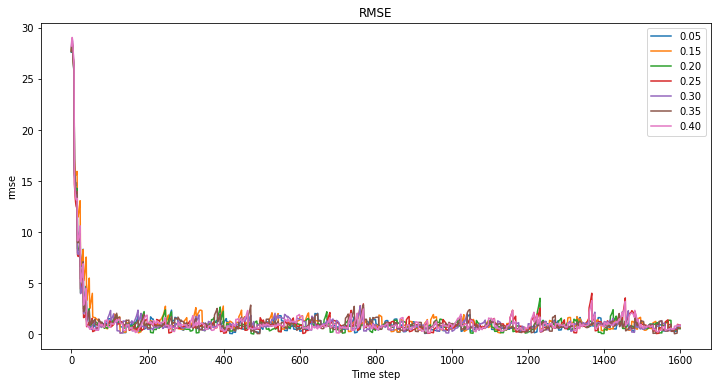

In [9]:
plt.figure(figsize=(12, 6))

for obsm in [0.05, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4]:
    key = f'{obsm:4.2f}'
    obs = ex_obs_dict[key]
    
    rng = np.random.RandomState(42)
    X_ens_ini = rng.multivariate_normal(X_nature[:,0], Pb, size=N_ens).T  # (3, N_ens)
    X_ens_ini += 55

    enkf_params = {
        'X_ens_ini': X_ens_ini, 
        'obs': obs, 
        'obs_interv': 8, 
        'R': R, 
        'H_func': None, 
        'alpha': 0.3,
        'inflat': 1.4
    }

    enkf = EnKF(lorenz63_fdm, dt)
    enkf.set_params(**enkf_params)
    enkf.cycle()
    enkf.analysis
    ens_mean = enkf.analysis.mean(axis=0)

    # calculate RMSE and stable index
    rmse_enkf = np.sqrt(np.mean((ens_mean-X_nature)**2, axis=0))
    print(f'obsm={obsm:.2f}, Mean RMSE={rmse_enkf.mean():.4f}, Variance RMSE={rmse_enkf.var():.4f}')
    print(f'No spinup: Mean RMSE={rmse_enkf[50:].mean():.4f}, Variance RMSE={rmse_enkf[50:].var():.4f}')

    plt.plot(rmse_enkf, label=key)
    
plt.legend()
plt.title('RMSE')
plt.xlabel('Time step')
plt.ylabel('rmse')

### Create bias observation and assimilation again

In [10]:
ex_obs_dict = {}
ex_mean = np.arange(0.2, 5.2+0.25, 0.25)

for ex_m in ex_mean:
    print(ex_m)
    obs_mean = [ex_m for _ in range(3)]
    obs_var = [2, 2, 2]
    random_state = [29, 21, 36]
    
    obs_timeintv = 0.08
    obs_intv = int(obs_timeintv / dt)
    cycle_num = int(time / obs_timeintv)
    
    size = int(time/dt)
    X_obs_err = np.zeros((3, size))
    for irow, (obsm, obsv, rst) in enumerate(zip(obs_mean, obs_var, random_state)):
        X_obs_err[irow,:] = gen_random_obserr(obsm, obsv, size, obs_intv, rst+np.random.randint(0, 10))

    ex_obs = X_nature + X_obs_err
    ex_obs = ex_obs[:,::obs_intv]
    
    key = f'{ex_m:4.2f}'
    ex_obs_dict[key] = ex_obs

0.2
0.45
0.7
0.95
1.2
1.45
1.7
1.95
2.2
2.45
2.7
2.95
3.2
3.45
3.7
3.95
4.2
4.45
4.7
4.95
5.2


obsm=0.20, Mean RMSE=1.2908, Variance RMSE=5.3139,  Without spinup: Mean RMSE=0.9906, Variance RMSE=0.1655
obsm=0.45, Mean RMSE=1.1751, Variance RMSE=5.0284,  Without spinup: Mean RMSE=0.8989, Variance RMSE=0.2271
obsm=0.70, Mean RMSE=1.2443, Variance RMSE=5.0138,  Without spinup: Mean RMSE=0.9931, Variance RMSE=0.2030
obsm=0.95, Mean RMSE=1.4260, Variance RMSE=5.0853,  Without spinup: Mean RMSE=1.1567, Variance RMSE=0.3055
obsm=1.20, Mean RMSE=1.5352, Variance RMSE=5.1943,  Without spinup: Mean RMSE=1.2868, Variance RMSE=0.4519
obsm=1.45, Mean RMSE=1.6362, Variance RMSE=5.0844,  Without spinup: Mean RMSE=1.3897, Variance RMSE=0.4858
obsm=1.70, Mean RMSE=1.8022, Variance RMSE=5.1384,  Without spinup: Mean RMSE=1.5545, Variance RMSE=0.5521
obsm=1.95, Mean RMSE=1.9628, Variance RMSE=5.4931,  Without spinup: Mean RMSE=1.6993, Variance RMSE=0.7114
obsm=2.20, Mean RMSE=2.1367, Variance RMSE=5.2132,  Without spinup: Mean RMSE=1.8877, Variance RMSE=0.8258
obsm=2.45, Mean RMSE=2.2402, Variance

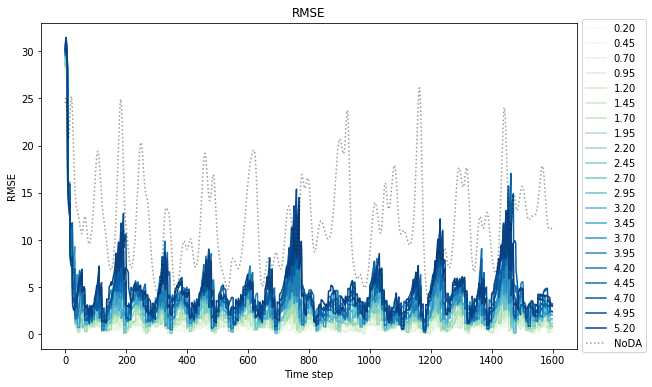

In [11]:
import matplotlib.cm as cm

colors = cm.GnBu(np.linspace(0, 1, len(ex_mean)))
plt.figure(figsize=(12, 6))

mean_rmse = []        # mean RMSE
mean_rmse_nospn = []  # mean RMSE without spin up periods
var_rmse = []
var_rmse_nospn = []

for obsm, color in zip(ex_mean, colors):
    key = f'{obsm:4.2f}'
    obs = ex_obs_dict[key]

    enkf_params = {
        'X_ens_ini': X_ens_ini, 
        'obs': obs, 
        'obs_interv': 8, 
        'R': R, 
        'H_func': None, 
        'alpha': 0.3,
        'inflat': 1.4
    }

    enkf = EnKF(lorenz63_fdm, dt)
    enkf.set_params(**enkf_params)
    enkf.cycle()
    ens_mean = enkf.analysis.mean(axis=0)

    # calculate RMSE and stable index
    rmse_enkf = np.sqrt(np.mean((ens_mean-X_nature)**2, axis=0))
    print(
        f'obsm={obsm:.2f}, Mean RMSE={rmse_enkf.mean():.4f}, Variance RMSE={rmse_enkf.var():.4f},  '
        + f'Without spinup: Mean RMSE={rmse_enkf[50:].mean():.4f}, Variance RMSE={rmse_enkf[50:].var():.4f}'
    )
    mean_rmse.append(rmse_enkf.mean())
    mean_rmse_nospn.append(rmse_enkf[50:].mean())
    var_rmse.append(rmse_enkf.var())
    var_rmse_nospn.append(rmse_enkf[50:].var())
    
    plt.plot(rmse_enkf, label=key, color=color)
    
# no DA
X_noda_ini = X_ens_ini[:,0] - 30
ts = np.arange(0, time, dt)
forecast = lorenz63_fdm(X_noda_ini, ts)
rmse_noda = np.sqrt(np.mean((forecast-X_nature)**2, axis=0))
plt.plot(rmse_noda, label='NoDA', color='k', ls='dotted', alpha=0.4)
    
ax = plt.gca()
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('RMSE')
plt.xlabel('Time step')
plt.ylabel('RMSE');

Text(0, 0.5, 'RMSE')

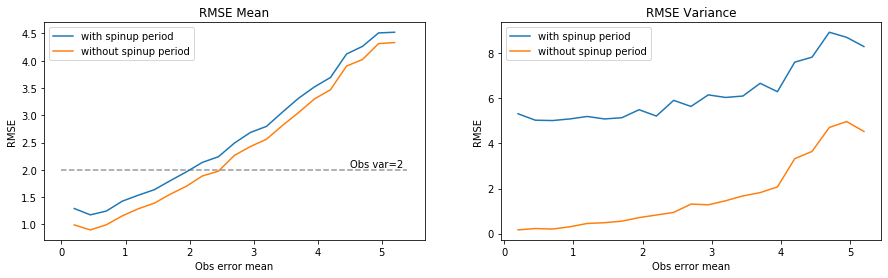

In [12]:
fig, axs = plt.subplots(ncols=2, figsize=(15, 4))

axs[0].plot(ex_mean, mean_rmse, label='with spinup period')
axs[0].plot(ex_mean, mean_rmse_nospn, label='without spinup period')
axs[0].legend()
axs[0].set_title('RMSE Mean')
axs[0].set_xlabel('Obs error mean')
axs[0].set_ylabel('RMSE')
axs[0].hlines(y=2, xmin=0, xmax=5.4, ls='dashed', alpha=0.4)
axs[0].text(4.5, 2.05, 'Obs var=2')

axs[1].plot(ex_mean, var_rmse, label='with spinup period')
axs[1].plot(ex_mean, var_rmse_nospn, label='without spinup period')
axs[1].legend()
axs[1].set_title('RMSE Variance')
axs[1].set_xlabel('Obs error mean')
axs[1].set_ylabel('RMSE')

# Third Moment

### create skew observatoin

In [13]:
from scipy.stats import skewnorm


def tskew(alpha):
    """給定alpha, 計算理論的偏度值"""
    d = alpha / np.sqrt(1+alpha**2)
    return (4-np.pi)/2 * (d*np.sqrt(2/np.pi)) ** 3 / (1-2*d**2/np.pi) ** (3/2)

def gen_skewnormal(mean, var, alpha, size, random_state=None):
    # generate standard skew normal distribution
    X = skewnorm.rvs(alpha, loc=0, scale=1, size=size, random_state=random_state)
    
    # theory expectation value (mean) and variance of standard skew normal distribution
    tmean = np.sqrt(2/np.pi) * alpha / np.sqrt(1+alpha**2)
    tvar = 1 - 2/np.pi * alpha**2 / (1+alpha**2)

    # (1)adjust var (2)adjust mean. Order can not reverse
    X = np.sqrt(var/tvar) * X
    tmean = np.sqrt(var/tvar) * np.sqrt(2/np.pi) * alpha / np.sqrt(1+alpha**2)
    X = X + mean - tmean
    
    return X

In [14]:
ex_obs_dict = {}
ex_alpha = [0.15, 0.45, 0.75, 1.05, 1.35]

for ex_a in ex_alpha:
    obs_mean = [0, 0, 0]
    obs_var = [2, 2, 2]
    
    obs_timeintv = 0.08
    obs_intv = int(obs_timeintv / dt)
    cycle_num = int(time / obs_timeintv)
    
    size = int(time/dt)
    X_obs_err = np.zeros((3, size))
    for irow, (obsm, obsv, rst) in enumerate(zip(obs_mean, obs_var, random_state)):
        # generate observations
        skew_obs = gen_skewnormal(obsm, obsv, ex_a, size)
        
        # set observations as 0 if it is not at the time of assimilation
        skew_obs_c = skew_obs.copy()
        skew_obs_c[::obs_intv] = 0
        skew_obs = skew_obs - skew_obs_c
        X_obs_err[irow,:] = skew_obs

    ex_obs = X_nature + X_obs_err
    ex_obs = ex_obs[:,::obs_intv]
    
    key = f'{ex_a:4.2f}'
    ex_obs_dict[key] = ex_obs

### assimilation skew observation

alpha=0.15, Mean RMSE=1.1857, Variance RMSE=4.8873,  Without spinup: Mean RMSE=0.9150, Variance RMSE=0.2007
alpha=0.45, Mean RMSE=1.1714, Variance RMSE=5.3087,  Without spinup: Mean RMSE=0.8729, Variance RMSE=0.1751
alpha=0.75, Mean RMSE=1.2001, Variance RMSE=4.8504,  Without spinup: Mean RMSE=0.9302, Variance RMSE=0.1925
alpha=1.05, Mean RMSE=1.2441, Variance RMSE=5.0770,  Without spinup: Mean RMSE=0.9860, Variance RMSE=0.2467
alpha=1.35, Mean RMSE=1.2503, Variance RMSE=5.4925,  Without spinup: Mean RMSE=0.9284, Variance RMSE=0.1861


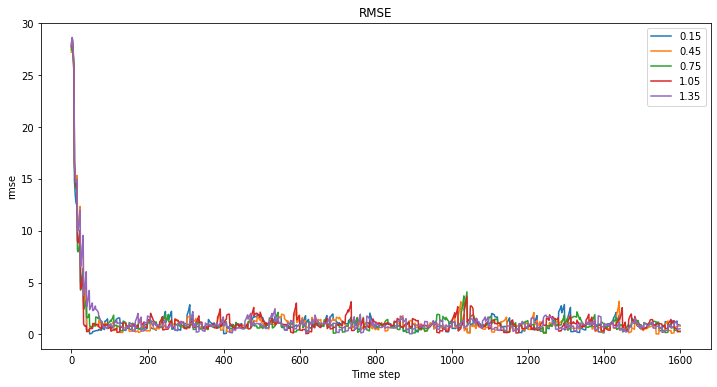

In [15]:
plt.figure(figsize=(12, 6))

for ex_a in ex_alpha:
    key = f'{ex_a:4.2f}'
    obs = ex_obs_dict[key]
    
    enkf_params = {
        'X_ens_ini': X_ens_ini, 
        'obs': obs, 
        'obs_interv': 8, 
        'R': R, 
        'H_func': None, 
        'alpha': 0.3,
        'inflat': 1.4
    }

    enkf = EnKF(lorenz63_fdm, dt)
    enkf.set_params(**enkf_params)
    enkf.cycle()
    enkf.analysis
    ens_mean = enkf.analysis.mean(axis=0)

    # calculate RMSE and stable index
    rmse_enkf = np.sqrt(np.mean((ens_mean-X_nature)**2, axis=0))
    print(
        f'alpha={ex_a:.2f}, Mean RMSE={rmse_enkf.mean():.4f}, Variance RMSE={rmse_enkf.var():.4f},  '
        + f'Without spinup: Mean RMSE={rmse_enkf[50:].mean():.4f}, Variance RMSE={rmse_enkf[50:].var():.4f}'
    )

    plt.plot(rmse_enkf, label=key)
    
plt.legend()
plt.title('RMSE')
plt.xlabel('Time step')
plt.ylabel('rmse');

### test which skewness value would be rejected in the Shapiro test with 200 samples

In [16]:
from scipy.stats import shapiro, jarque_bera

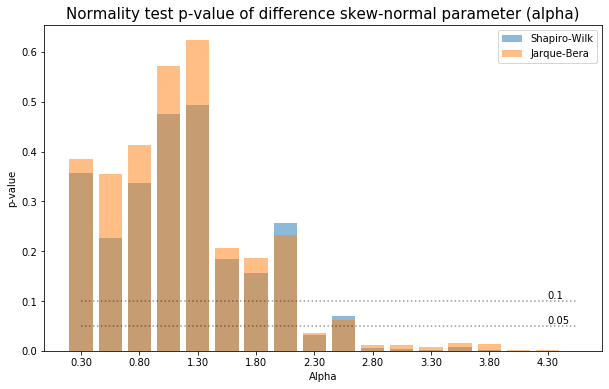

In [17]:
alphas = np.arange(0.3, 4.3+0.25, 0.25)
N = 10

shapiro_p = np.zeros((N, len(alphas)))
jarque_p = np.zeros_like(shapiro_p)

for i in range(N):
    for j, alpha in enumerate(alphas):
        samples = gen_skewnormal(0, 2, alpha, 200)
        sp = shapiro(samples)[1]
        jp = jarque_bera(samples)[1]
        shapiro_p[i,j] = sp
        jarque_p[i,j] = jp
    
shapiro_p = shapiro_p.mean(axis=0)
jarque_p = jarque_p.mean(axis=0)

plt.figure(figsize=(10, 6))
x = list(range(len(alphas)))
plt.bar(x, shapiro_p, alpha=0.5, label='Shapiro-Wilk')
plt.bar(x, jarque_p, alpha=0.5, label='Jarque-Bera')
plt.legend()

xticklabels = [f'{a:4.2f}' for a in alphas]
plt.xticks(x[::2], xticklabels[::2])
plt.hlines([0.1, 0.05], xmin=0, xmax=len(alphas), ls='dotted', alpha=0.4)
plt.text(len(alphas)-1, 0.105, '0.1')
plt.text(len(alphas)-1, 0.055, '0.05')
plt.xlabel('Alpha')
plt.ylabel('p-value')
plt.title('Normality test p-value of difference skew-normal parameter (alpha)', fontsize=15);

### create skew observation and assimilation again

In [20]:
ex_obs_dict = {}
ex_alpha = [1.3, 1.55, 1.8, 2.05, 2.3, 2.55, 2.8, 3.05, 3.3]

for ex_a in ex_alpha:
    obs_mean = [0, 0, 0]
    obs_var = [2, 2, 2]
    
    obs_timeintv = 0.08
    obs_intv = int(obs_timeintv / dt)
    cycle_num = int(time / obs_timeintv)
    
    size = int(time/dt)
    X_obs_err = np.zeros((3, size))
    for irow, (obsm, obsv, rst) in enumerate(zip(obs_mean, obs_var, random_state)):
        # generate observations
        skew_obs = gen_skewnormal(obsm, obsv, ex_a, size)
        
        # set observations as 0 if it is not at the time of assimilation
        skew_obs_c = skew_obs.copy()
        skew_obs_c[::obs_intv] = 0
        skew_obs = skew_obs - skew_obs_c
        X_obs_err[irow,:] = skew_obs

    ex_obs = X_nature + X_obs_err
    ex_obs = ex_obs[:,::obs_intv]
    
    key = f'{ex_a:4.2f}'
    ex_obs_dict[key] = ex_obs

alpha=1.30, Mean RMSE=1.2135, Variance RMSE=5.4046,  Without spinup: Mean RMSE=0.9088, Variance RMSE=0.1737
alpha=1.55, Mean RMSE=1.1214, Variance RMSE=5.6402,  Without spinup: Mean RMSE=0.8029, Variance RMSE=0.1894
alpha=1.80, Mean RMSE=1.1827, Variance RMSE=5.1257,  Without spinup: Mean RMSE=0.9037, Variance RMSE=0.1886
alpha=2.05, Mean RMSE=1.1442, Variance RMSE=5.0030,  Without spinup: Mean RMSE=0.8764, Variance RMSE=0.1965
alpha=2.30, Mean RMSE=1.1282, Variance RMSE=5.2054,  Without spinup: Mean RMSE=0.8558, Variance RMSE=0.1532
alpha=2.55, Mean RMSE=1.1686, Variance RMSE=5.0445,  Without spinup: Mean RMSE=0.9087, Variance RMSE=0.1504
alpha=2.80, Mean RMSE=1.2210, Variance RMSE=5.4274,  Without spinup: Mean RMSE=0.9269, Variance RMSE=0.2080
alpha=3.05, Mean RMSE=1.2247, Variance RMSE=4.7619,  Without spinup: Mean RMSE=0.9555, Variance RMSE=0.1562
alpha=3.30, Mean RMSE=1.1582, Variance RMSE=4.6765,  Without spinup: Mean RMSE=0.9023, Variance RMSE=0.1355


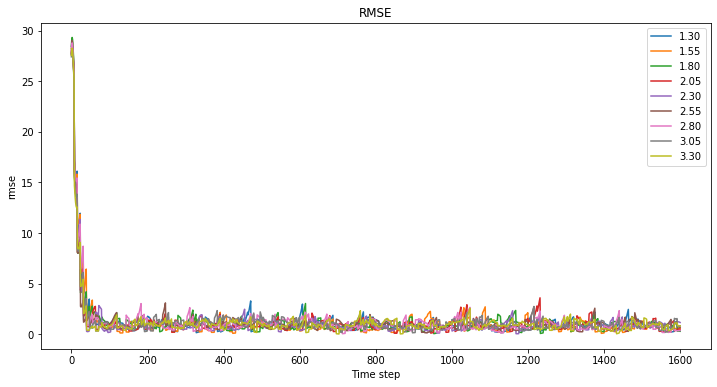

In [21]:
plt.figure(figsize=(12, 6))

for ex_a in ex_alpha:
    key = f'{ex_a:4.2f}'
    obs = ex_obs_dict[key]
    
    enkf_params = {
        'X_ens_ini': X_ens_ini, 
        'obs': obs, 
        'obs_interv': 8, 
        'R': R, 
        'H_func': None, 
        'alpha': 0.3,
        'inflat': 1.4
    }

    enkf = EnKF(lorenz63_fdm, dt)
    enkf.set_params(**enkf_params)
    enkf.cycle()
    enkf.analysis
    ens_mean = enkf.analysis.mean(axis=0)

    # calculate RMSE and stable index
    rmse_enkf = np.sqrt(np.mean((ens_mean-X_nature)**2, axis=0))
    print(
        f'alpha={ex_a:.2f}, Mean RMSE={rmse_enkf.mean():.4f}, Variance RMSE={rmse_enkf.var():.4f},  '
        + f'Without spinup: Mean RMSE={rmse_enkf[50:].mean():.4f}, Variance RMSE={rmse_enkf[50:].var():.4f}'
    )

    plt.plot(rmse_enkf, label=key)
    
plt.legend()
plt.title('RMSE')
plt.xlabel('Time step')
plt.ylabel('rmse');

### check if sample skewness is close to theory skew value

In [22]:
from scipy.stats import skew

for ex_a in ex_alpha:
    key = f'{ex_a:.2f}'
    print('Alpha = ', key, ':')
    obs = ex_obs_dict[key]
    
    obs_err = np.zeros_like(obs)
    for irow in range(obs_err.shape[0]):
        obs_err[irow,:] = obs[irow,:] - X_nature[irow,::obs_intv]
    
    theory_skew = tskew(ex_a)
    sample_skew = [skew(obs_err[irow,:]) for irow in range(obs_err.shape[0])]
    
    print(f'Theory Skew: {theory_skew:.4f}')
    print('Sample Skew:', f'{sample_skew[0]:.4f}, {sample_skew[1]:.4f}, {sample_skew[2]:.4f}')
    print()

Alpha =  1.30 :
Theory Skew: 0.2336
Sample Skew: 0.0106, 0.1992, 0.2813

Alpha =  1.55 :
Theory Skew: 0.3167
Sample Skew: 0.2454, 0.1064, 0.1727

Alpha =  1.80 :
Theory Skew: 0.3957
Sample Skew: 0.1816, 0.4964, 0.3489

Alpha =  2.05 :
Theory Skew: 0.4675
Sample Skew: 0.6876, 0.4182, 0.2357

Alpha =  2.30 :
Theory Skew: 0.5310
Sample Skew: 0.3300, 0.6193, 0.7017

Alpha =  2.55 :
Theory Skew: 0.5862
Sample Skew: 0.3983, 0.2968, 0.8847

Alpha =  2.80 :
Theory Skew: 0.6338
Sample Skew: 0.6567, 0.4049, 0.9839

Alpha =  3.05 :
Theory Skew: 0.6747
Sample Skew: 0.6890, 0.7696, 0.7389

Alpha =  3.30 :
Theory Skew: 0.7099
Sample Skew: 0.9675, 0.6723, 0.5603



### use rainfall data and find its skewness

In [23]:
rain = np.load('rain.npy')  # (ensemble, time, lat, lon)
# use ensemble mean
rain = rain.mean(axis=0)
# only use the middle period
rain = rain[50:60,:,:].mean(axis=0)
rain.shape

(222, 138)

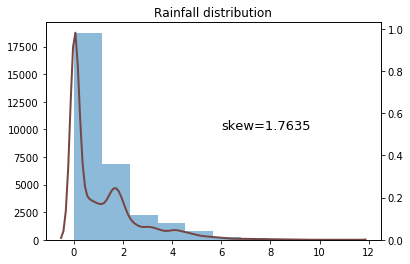

In [24]:
import seaborn as sns

fig, ax = plt.subplots()
ax.hist(rain.ravel(), alpha=0.5)
ax.set_title('Rainfall distribution')
ax.text(6, 10000, f'skew={skew(rain.ravel()):.4f}', fontsize=13)

ax2 = ax.twinx()
sns.kdeplot(rain.ravel(), lw=2, color='#764645', ax=ax2);

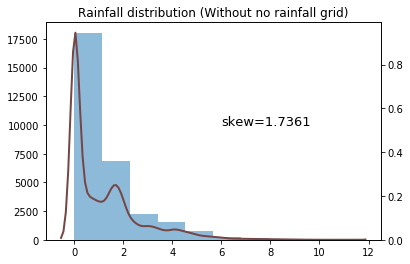

In [25]:
# check the distribution without no rainfall grids
rain_no0 = rain.ravel()[rain.ravel() != 0]

fig, ax = plt.subplots()
ax.hist(rain_no0.ravel(), alpha=0.5)
ax.set_title('Rainfall distribution (Without no rainfall grid)')
ax.text(6, 10000, f'skew={skew(rain_no0.ravel()):.4f}', fontsize=13)

ax2 = ax.twinx()
sns.kdeplot(rain_no0.ravel(), lw=2, color='#764645', ax=ax2);

In [26]:
tskew(100000)

0.9952717460203186

In [27]:
# Theory max skewness of skewnorm distribution
(4-np.pi) / (np.pi-2) * np.sqrt(2 / (np.pi-2))

0.9952717464311563

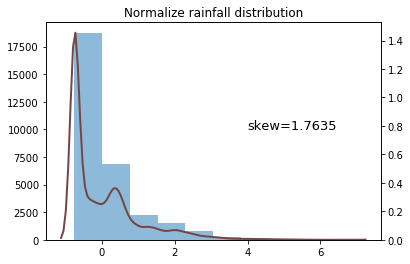

In [28]:
normalize_rain = (rain.ravel() - rain.mean()) / np.sqrt(rain.var())

fig, ax = plt.subplots()
ax.hist(normalize_rain, alpha=0.5)
ax.set_title('Normalize rainfall distribution')
ax.text(4, 10000, f'skew={skew(normalize_rain):.4f}', fontsize=13)

ax2 = ax.twinx()
sns.kdeplot(normalize_rain, lw=2, color='#764645', ax=ax2);

### Use normalize rainfall distribution as the observation error distribution, and assimilate it

Statistics of this fake population:
Mean = 0.000
Var  = 2.000
Skew = 1.763


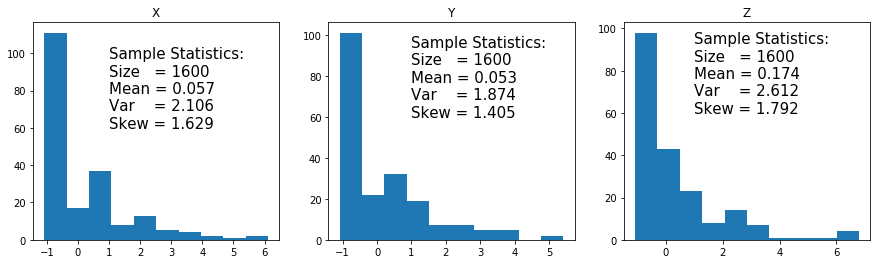

In [29]:
# adjust to var=2
nrain_var2 = normalize_rain * np.sqrt(2)
print('Statistics of this fake population:')
print(f'Mean = {nrain_var2.mean():.3f}')
print(f'Var  = {nrain_var2.var():.3f}')
print(f'Skew = {skew(nrain_var2):.3f}')

# sample
ndim, obs_size = X_obs.shape
nrain_obserr = np.zeros((ndim, X_nature.shape[1]))
for i in range(ndim):
    nrain_obserr[i,:] = np.random.choice(nrain_var2, size=X_nature.shape[1])

tmp = nrain_obserr.copy()
tmp[:,::obs_intv] = 0
nrain_obserr -= tmp

nrain_obs = X_nature + nrain_obserr
nrain_obs = nrain_obs[:,::obs_intv]

# plot the distribution of nrain_obserr
fig, axs = plt.subplots(ncols=ndim, figsize=(15, 4))
for i, ax in enumerate(axs):
    ax.hist(nrain_obserr[i,::obs_intv])
    text = (
        'Sample Statistics:\n'
        f'Size   = {size}\n'
        f'Mean = {nrain_obserr[i,::obs_intv].mean():.3f}\n'
        f'Var    = {nrain_obserr[i,::obs_intv].var():.3f}\n'
        f'Skew = {skew(nrain_obserr[i,::obs_intv]):.3f}'
    )
    ax.text(1, 60, text, fontsize=15)
    ax.set_title(chr(ord('X')+i))

1.161820803179443


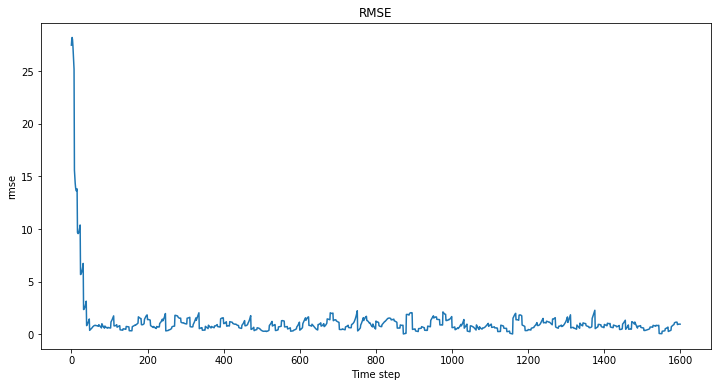

In [30]:
plt.figure(figsize=(12, 6))

enkf_params = {
    'X_ens_ini': X_ens_ini, 
    'obs': nrain_obs, 
    'obs_interv': 8, 
    'R': R, 
    'H_func': None, 
    'alpha': 0.3,
    'inflat': 1.4
}
enkf = EnKF(lorenz63_fdm, dt)
enkf.set_params(**enkf_params)
enkf.cycle()
enkf.analysis
ens_mean = enkf.analysis.mean(axis=0)

rmse_enkf = np.sqrt(np.mean((ens_mean-X_nature)**2, axis=0))
plt.plot(rmse_enkf)
plt.title('RMSE')
plt.xlabel('Time step')
plt.ylabel('rmse')

print(rmse_enkf.mean())

In [31]:
rmse_enkf.mean()

1.161820803179443

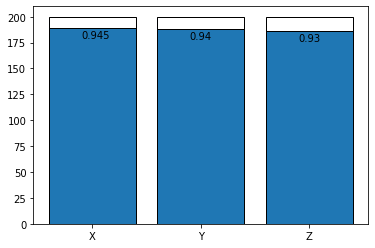

In [32]:
# check the ratio of this rainfall observation error that exceed to 2*std

within = (np.abs(nrain_obserr[:,::obs_intv]) <= 2*np.sqrt(np.array(obs_var)[:,np.newaxis])).sum(axis=1)
total = nrain_obserr[:,::obs_intv].shape[1]
ratio = within / total

plt.bar([0, 1, 2], total, edgecolor='k', color='white')
plt.bar([0, 1, 2], within, edgecolor='k')
for i in range(3):
    plt.text(i-0.1, within[i]-10, str(ratio[i]))
plt.xticks([0, 1, 2], ['X', 'Y', 'Z']);

In [33]:
## 看看前面同化降雨分布的實驗裡，RMSE的上升有多少是因為不穩定，又有多少是因為skew的outlier

# Fourth Moment

In [34]:
from scipy.stats import kurtosis
from scipy.special import erf, erfinv

def invcdf(x, mean, var, epsilon, delta):
    """inverse CDF of sinh-arcsinh transform of normal distrubution"""
    return np.sinh(epsilon/delta + 1/delta * np.arcsinh(mean + np.sqrt(2*var) * erfinv(2*x-1)))

def gen_kurtosis_normal(size, mean, var, epsilon, delta):
    u = np.random.rand(size)
    samples = invcdf(u, mean, var, epsilon, delta)
    return samples

def est_tvar(delta, size=1000, times=1000):
    """estimate theory variance"""
    variances = np.zeros((times,))
    for i in range(times):
        u = np.random.rand(size)
        samples = invcdf(u, 0, 2, 0, delta)
        variances[i] = samples.var()
    return np.mean(variances)

### generate kurtosis observations and assimilate

In [35]:
ex_delta = [
    0.5, 0.6, 0.7, 0.8,    # reject H0 
    0.9, 1.2,              # accept H0
    1.6, 1.8, 2, 2.2       # reject H0
]

ex_obs_dict = {}

for ex_d in ex_delta:
    obs_mean = [0, 0, 0]
    obs_var = [2, 2, 2]
    
    obs_timeintv = 0.08
    obs_intv = int(obs_timeintv / dt)
    cycle_num = int(time / obs_timeintv)
    
    size = int(time/dt)
    X_obs_err = np.zeros((3, size))
    for irow, (obsm, obsv) in enumerate(zip(obs_mean, obs_var)):
        # generate observations
        kurt_obs = gen_kurtosis_normal(size, obsm, obsv, 0, ex_d)
        # adjust to given obs variance
        kurt_obs = kurt_obs * np.sqrt(obsv / est_tvar(ex_d))
        
        # set observations as 0 if it is not at the time of assimilation
        kurt_obs_c = kurt_obs.copy()
        kurt_obs_c[::obs_intv] = 0
        kurt_obs = kurt_obs - kurt_obs_c
        X_obs_err[irow,:] = kurt_obs

    ex_obs = X_nature + X_obs_err
    ex_obs = ex_obs[:,::obs_intv]
    
    key = f'{ex_d:.1f}'
    ex_obs_dict[key] = ex_obs

In [36]:
ex_obs_dict['0.5'].shape

(3, 200)

delta=0.50, Mean RMSE=1.2459, Variance RMSE=5.7346,  Without spinup: Mean RMSE=0.9019, Variance RMSE=0.2119
delta=0.60, Mean RMSE=1.2233, Variance RMSE=5.0909,  Without spinup: Mean RMSE=0.9597, Variance RMSE=0.3131
delta=0.70, Mean RMSE=1.1942, Variance RMSE=4.8800,  Without spinup: Mean RMSE=0.9393, Variance RMSE=0.2003
delta=0.80, Mean RMSE=1.1442, Variance RMSE=5.0947,  Without spinup: Mean RMSE=0.8587, Variance RMSE=0.1834
delta=0.90, Mean RMSE=1.1614, Variance RMSE=4.8698,  Without spinup: Mean RMSE=0.8762, Variance RMSE=0.1418
delta=1.20, Mean RMSE=1.1460, Variance RMSE=4.8793,  Without spinup: Mean RMSE=0.8812, Variance RMSE=0.1698
delta=1.60, Mean RMSE=1.1483, Variance RMSE=5.3377,  Without spinup: Mean RMSE=0.8459, Variance RMSE=0.1543
delta=1.80, Mean RMSE=1.2250, Variance RMSE=5.0549,  Without spinup: Mean RMSE=0.9469, Variance RMSE=0.1738
delta=2.00, Mean RMSE=1.2355, Variance RMSE=4.9488,  Without spinup: Mean RMSE=0.9819, Variance RMSE=0.1807
delta=2.20, Mean RMSE=1.1695

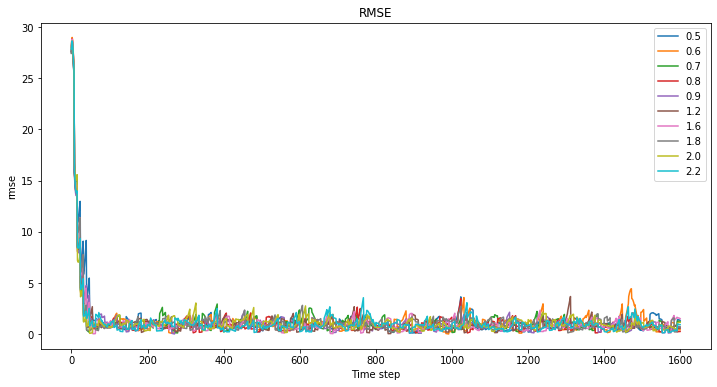

In [37]:
plt.figure(figsize=(12, 6))

for ex_d in ex_delta:
    key = f'{ex_d:.1f}'
    obs = ex_obs_dict[key]
    
    enkf_params = {
        'X_ens_ini': X_ens_ini, 
        'obs': obs, 
        'obs_interv': 8, 
        'R': R, 
        'H_func': None, 
        'alpha': 0.3,
        'inflat': 1.4
    }

    enkf = EnKF(lorenz63_fdm, dt)
    enkf.set_params(**enkf_params)
    enkf.cycle()
    enkf.analysis
    ens_mean = enkf.analysis.mean(axis=0)

    # calculate RMSE and stable index
    rmse_enkf = np.sqrt(np.mean((ens_mean-X_nature)**2, axis=0))
    print(
        f'delta={ex_d:.2f}, Mean RMSE={rmse_enkf.mean():.4f}, Variance RMSE={rmse_enkf.var():.4f},  '
        + f'Without spinup: Mean RMSE={rmse_enkf[50:].mean():.4f}, Variance RMSE={rmse_enkf[50:].var():.4f}'
    )

    plt.plot(rmse_enkf, label=key)
    
plt.legend()
plt.title('RMSE')
plt.xlabel('Time step')
plt.ylabel('rmse');

(-20, 20)

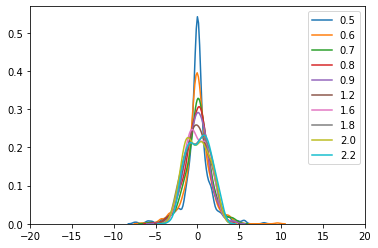

In [38]:
fig, ax = plt.subplots()

for key in ex_obs_dict.keys():
    obs = ex_obs_dict[key]
    obserr = obs - X_nature[:,::obs_intv]
    obserr = obserr.ravel()
    sns.kdeplot(obserr, label=key, ax=ax)
plt.xlim([-20, 20])

### test more extreme delta

In [39]:
ex_delta = [0.1, 0.2, 0.3, 0.4, 2.5, 2.8, 3.1, 3.4]

ex_obs_dict = {}

for ex_d in ex_delta:
    obs_mean = [0, 0, 0]
    obs_var = [2, 2, 2]
    
    obs_timeintv = 0.08
    obs_intv = int(obs_timeintv / dt)
    cycle_num = int(time / obs_timeintv)
    
    size = int(time/dt)
    X_obs_err = np.zeros((3, size))
    for irow, (obsm, obsv) in enumerate(zip(obs_mean, obs_var)):
        # generate observations
        kurt_obs = gen_kurtosis_normal(size, obsm, obsv, 0, ex_d)
        # adjust to given obs variance
        kurt_obs = kurt_obs * np.sqrt(obsv / est_tvar(ex_d))
        
        # set observations as 0 if it is not at the time of assimilation
        kurt_obs_c = kurt_obs.copy()
        kurt_obs_c[::obs_intv] = 0
        kurt_obs = kurt_obs - kurt_obs_c
        X_obs_err[irow,:] = kurt_obs

    ex_obs = X_nature + X_obs_err
    ex_obs = ex_obs[:,::obs_intv]
    
    key = f'{ex_d:.1f}'
    ex_obs_dict[key] = ex_obs

delta=0.10, Mean RMSE=1.0525, Variance RMSE=5.7641,  Without spinup: Mean RMSE=0.7820, Variance RMSE=1.0125
delta=0.20, Mean RMSE=0.9381, Variance RMSE=4.7281,  Without spinup: Mean RMSE=0.7020, Variance RMSE=0.2118
delta=0.30, Mean RMSE=1.0793, Variance RMSE=5.0589,  Without spinup: Mean RMSE=0.8084, Variance RMSE=0.2817
delta=0.40, Mean RMSE=1.1324, Variance RMSE=5.1334,  Without spinup: Mean RMSE=0.8539, Variance RMSE=0.2362
delta=2.50, Mean RMSE=1.1531, Variance RMSE=4.7329,  Without spinup: Mean RMSE=0.8849, Variance RMSE=0.1679
delta=2.80, Mean RMSE=1.1299, Variance RMSE=4.7487,  Without spinup: Mean RMSE=0.8737, Variance RMSE=0.1373
delta=3.10, Mean RMSE=1.1636, Variance RMSE=5.0078,  Without spinup: Mean RMSE=0.8749, Variance RMSE=0.1617
delta=3.40, Mean RMSE=1.1602, Variance RMSE=4.9156,  Without spinup: Mean RMSE=0.9001, Variance RMSE=0.1883


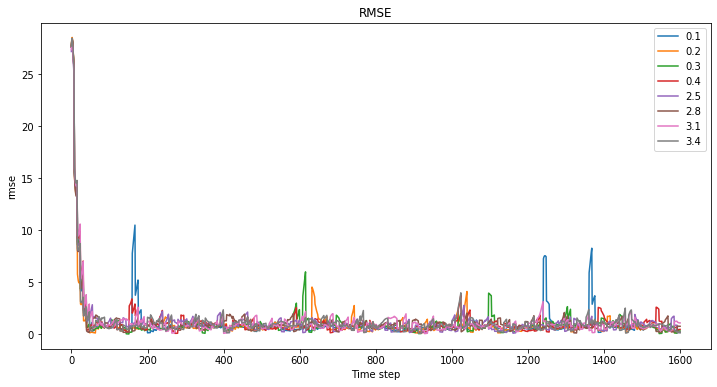

In [40]:
plt.figure(figsize=(12, 6))

for ex_d in ex_delta:
    key = f'{ex_d:.1f}'
    obs = ex_obs_dict[key]
    
    enkf_params = {
        'X_ens_ini': X_ens_ini, 
        'obs': obs, 
        'obs_interv': 8, 
        'R': R, 
        'H_func': None, 
        'alpha': 0.3,
        'inflat': 1.4
    }

    enkf = EnKF(lorenz63_fdm, dt)
    enkf.set_params(**enkf_params)
    enkf.cycle()
    enkf.analysis
    ens_mean = enkf.analysis.mean(axis=0)

    # calculate RMSE and stable index
    rmse_enkf = np.sqrt(np.mean((ens_mean-X_nature)**2, axis=0))
    print(
        f'delta={ex_d:.2f}, Mean RMSE={rmse_enkf.mean():.4f}, Variance RMSE={rmse_enkf.var():.4f},  '
        + f'Without spinup: Mean RMSE={rmse_enkf[50:].mean():.4f}, Variance RMSE={rmse_enkf[50:].var():.4f}'
    )

    plt.plot(rmse_enkf, label=key)
    
plt.legend()
plt.title('RMSE')
plt.xlabel('Time step')
plt.ylabel('rmse');

(0, 5)

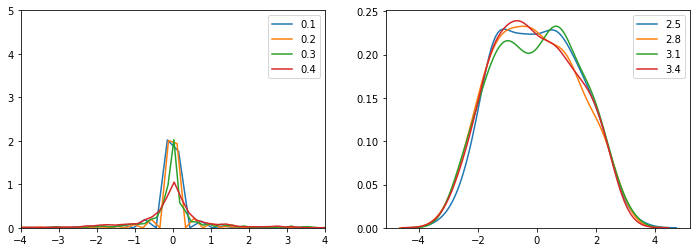

In [41]:
fig, axs = plt.subplots(ncols=2, figsize=(12, 4))

for key in ex_obs_dict.keys():
    if float(key) < 1:
        ax = axs[0]
    else:
        ax = axs[1]
    obs = ex_obs_dict[key]
    obserr = obs - X_nature[:,::obs_intv]
    obserr = obserr.ravel()
    sns.kdeplot(obserr, label=key, ax=ax)
axs[0].set_xlim([-4, 4])
axs[0].set_ylim([0, 5])